Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/work-with-data/datasets-tutorial/labeled-datasets/labeled-datasets.png)

# Introduction to labeled datasets

Labeled datasets are output from Azure Machine Learning [labeling projects](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-create-labeling-projects). It captures the reference to the data (e.g. image files) and its labels. 

This tutorial introduces the capabilities of labeled datasets and how to use it in training.

Learn how-to:

> * Set up your development environment
> * Explore labeled datasets
> * Train a simple deep learning neural network on a remote cluster

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* Go through Azure Machine Learning [labeling projects](https://docs.microsoft.com/azure/machine-learning/service/how-to-create-labeling-projects) and export the labels as an Azure Machine Learning dataset
* Go through the [configuration notebook](../../../configuration.ipynb) to:
    * install the latest version of azureml-sdk
    * install the latest version of azureml-contrib-dataset
    * install [PyTorch](https://pytorch.org/)
    * create a workspace and its configuration file (`config.json`)

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [43]:
import os
import azureml.core
import azureml.contrib.dataset
from azureml.core import Dataset, Workspace, Experiment
from azureml.contrib.dataset import FileHandlingOption

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)
print("Azure ML Contrib Version", azureml.contrib.dataset.VERSION)

Azure ML SDK Version:  1.1.5
Azure ML Contrib Version 1.1.5


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `workspace`.

In [44]:
# load workspace
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="ac5c5e7c-0141-491a-a5dd-d3608633ce62")
workspace = Workspace.from_config()
print('Workspace name: ' + workspace.name, 
      'Azure region: ' + workspace.location, 
      'Subscription id: ' + workspace.subscription_id, 
      'Resource group: ' + workspace.resource_group, sep='\n')

Workspace name: wsAzureNoteBooks
Azure region: eastus
Subscription id: 01644559-ad8e-40d4-9bf2-6c5e3213a8bf
Resource group: rgAzureNotebooks


### Create experiment and a directory

Create an experiment to track the runs in your workspace and a directory to deliver the necessary code from your computer to the remote resource.

In [45]:
# create an ML experiment
exp = Experiment(workspace=workspace, name='labeled-datasets2')

# create a directory
script_folder = './labeled-datasets2'
os.makedirs(script_folder, exist_ok=True)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you will create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [46]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "openhack"

try:
    compute_target = ComputeTarget(workspace=workspace, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(workspace, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-03-28T17:32:27.295000+00:00', 'errors': None, 'creationTime': '2020-03-22T23:41:35.638596+00:00', 'modifiedTime': '2020-03-22T23:41:53.584716+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


## Explore labeled datasets

**Note**: How to create labeled datasets is not covered in this tutorial. To create labeled datasets, you can go through [labeling projects](https://docs.microsoft.com/azure/machine-learning/service/how-to-create-labeling-projects) and export the output labels as Azure Machine Lerning datasets. 

`animal_labels` used in this tutorial section is the output from a labeling project, with the task type of "Object Identification".

In [47]:
# get animal_labels dataset from the workspace
animal_labels = Dataset.get_by_name(workspace, 'datalabellingclass2-2020-03-28 17:15:25')
animal_labels

{
  "source": [
    "('workspaceblobstore', '/export/dataset/ecbdf99b-1326-c12a-4636-bdb3980769d6/22bfb896-af6e-4388-a3b4-c0d8aa13133f/d6b1eec8-448f-4ecf-8c63-fad8863020e6/LabeledDatasetJsonLines.json')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseJsonLines",
    "ExpressionAddColumn",
    "DropColumns",
    "DropColumns",
    "RenameColumns"
  ],
  "registration": {
    "id": "83fa5941-4281-440a-829d-4b79a498edad",
    "name": "datalabellingclass2-2020-03-28 17:15:25",
    "version": 1,
    "description": "LabeledDs_datalabellingclass2 Of Type ImageClassificationMultiClass, Sourced From 22bfb896-af6e-4388-a3b4-c0d8aa13133f",
    "workspace": "Workspace.create(name='wsAzureNoteBooks', subscription_id='01644559-ad8e-40d4-9bf2-6c5e3213a8bf', resource_group='rgAzureNotebooks')"
  }
}

You can load labeled datasets into pandas DataFrame. There are 3 file handling option that you can choose to load the data files referenced by the labeled datasets:
* Streaming: The default option to load data files.
* Download: Download your data files to a local path.
* Mount: Mount your data files to a mount point. Mount only works for Linux-based compute, including Azure Machine Learning notebook VM and Azure Machine Learning Compute.

In [48]:
animal_pd = animal_labels.to_pandas_dataframe(file_handling_option=FileHandlingOption.DOWNLOAD, target_path='./download/', overwrite_download=True)
animal_pd

,image_url,label,label_confidence
0,E:\Personal\som\work\MLAI\code\MachineLearning...,sheep,1.0
1,E:\Personal\som\work\MLAI\code\MachineLearning...,sheep,1.0
2,E:\Personal\som\work\MLAI\code\MachineLearning...,chicken,1.0
3,E:\Personal\som\work\MLAI\code\MachineLearning...,Dog,1.0
4,E:\Personal\som\work\MLAI\code\MachineLearning...,squirrel,1.0
5,E:\Personal\som\work\MLAI\code\MachineLearning...,butterfly,1.0
6,E:\Personal\som\work\MLAI\code\MachineLearning...,Dog,1.0
7,E:\Personal\som\work\MLAI\code\MachineLearning...,squirrel,1.0
8,E:\Personal\som\work\MLAI\code\MachineLearning...,Horse,1.0
9,E:\Personal\som\work\MLAI\code\MachineLearning...,spider,1.0


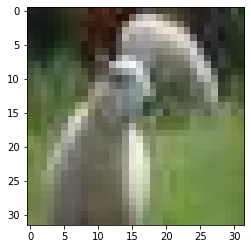

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# read images from downloaded path
img = mpimg.imread(animal_pd.loc[0,'image_url'])
imgplot = plt.imshow(img)

You can also load labeled datasets into [torchvision datasets](https://pytorch.org/docs/stable/torchvision/datasets.html), so that you can leverage on the open source libraries provided by PyTorch for image transformation and training.

[18, 22, 43, 11, 39, 40, 10, 19, 24, 5, 44, 2, 0, 23, 6, 27, 9, 42, 29, 15, 8, 16, 41, 36, 30, 17, 14, 26, 48, 28, 35, 46, 25, 4, 37, 3, 7, 31, 49, 34, 45, 33, 1, 13, 38, 32, 47, 20, 12, 21]
<class 'torch.Tensor'>


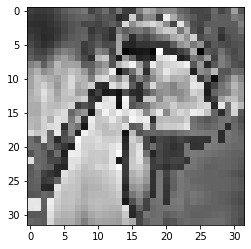

In [49]:
from torchvision.transforms import functional as F
import torch
# load animal_labels dataset into torchvision dataset
pytorch_dataset = animal_labels.to_torchvision()

indices = torch.randperm(len(pytorch_dataset)).tolist()
print(indices)
dataset_train = torch.utils.data.Subset(pytorch_dataset, indices[:40])
print(dataset_train)
dataset_test = torch.utils.data.Subset(pytorch_dataset, indices[-10:])
print(dataset_test)

img = pytorch_dataset[0][0]
print(type(img))

# use methods from torchvision to transform the img into grayscale
pil_image = F.to_pil_image(img)
gray_image = F.to_grayscale(pil_image, num_output_channels=3)

imgplot = plt.imshow(gray_image)

## Train an image classification model

 `crack_labels` dataset used in this tutorial section is the output from a labeling project, with the task type of "Image Classification Multi-class". We will use this dataset to train an image classification model that classify whether an image has cracks or not.

In [ ]:
# get crack_labels dataset from the workspace
crack_labels = Dataset.get_by_name(workspace, 'crack_labels')
crack_labels

### Configure Estimator for training

You can ask the system to build a conda environment based on your dependency specification. Once the environment is built, and if you don't change your dependencies, it will be reused in subsequent runs.

In [50]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk',
                                                                             'azureml-contrib-dataset',
                                                                             'torch','torchvision',
                                                                             'azureml-dataprep[pandas]',
                                                                             'azureml-dataprep==1.3.5',
                                                                             'azureml-defaults'])                              
                                                                        

An estimator object is used to submit the run. Azure Machine Learning has pre-configured estimators for common machine learning frameworks, as well as generic Estimator. Create a generic estimator for by specifying

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The training script name, train.py
* The input dataset for training
* The compute target. In this case you will use the AmlCompute you created
* The environment definition for the experiment

In [51]:
from azureml.train.estimator import Estimator

est = Estimator(source_directory=script_folder, 
                entry_script='train.py',
                inputs=[animal_labels.as_named_input('animal_labels')],
                compute_target=compute_target,
                environment_definition= conda_env)

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


### Submit job to run

Submit the estimator to the Azure ML experiment to kick off the execution.

In [52]:
run = exp.submit(est)

In [ ]:
run.wait_for_completion(show_output=True)

RunId: labeled-datasets2_1585426919_379f0fc3
Web View: https://ml.azure.com/experiments/labeled-datasets2/runs/labeled-datasets2_1585426919_379f0fc3?wsid=/subscriptions/01644559-ad8e-40d4-9bf2-6c5e3213a8bf/resourcegroups/rgAzureNotebooks/workspaces/wsAzureNoteBooks

Streaming azureml-logs/55_azureml-execution-tvmps_1ca46c0fc5fd00c346ef01b55c5f6ab863b5500b37e1792fd5fdebc8a7346f04_d.txt

2020-03-28T20:25:46Z Starting output-watcher...
2020-03-28T20:25:46Z IsDedicatedCompute == True, won't poll for Low Pri Preemption
Login Succeeded
Using default tag: latest
latest: Pulling from azureml/azureml_0c8ac77e582d7a921252125bbbdfac95
a1298f4ce990: Pulling fs layer
04a3282d9c4b: Pulling fs layer
9b0d3db6dc03: Pulling fs layer
8269c605f3f1: Pulling fs layer
6504d449e70c: Pulling fs layer
4e38f320d0d4: Pulling fs layer
b0a763e8ee03: Pulling fs layer
11917a028ca4: Pulling fs layer
a6c378d11cbf: Pulling fs layer
8269c605f3f1: Waiting
6cc007ad9140: Pulling fs layer
6504d449e70c: Waiting
6c1698a608f3: 